## MBA em Ciência de Dados
# Redes Neurais e Arquiteturas Profundas

### <span style="color:darkred">Módulo 4 - Estratégias de Treinamento e Transferência de Aprendizado</span>

#### <span style="color:darkred">**Parte 2: Aumentação de Dados e Transferência de Aprendizado**</span>

Moacir Antonelli Ponti

CeMEAI - ICMC/USP São Carlos

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from numpy.random import seed
from tensorflow.random import set_seed

import tensorflow_datasets as tfds

#tfds.disable_progress_bar()

# selecionamos 50% do treinamento
(train_ds, validation_ds, test_ds), info = tfds.load(
    "beans",
    split=["train[0%:50%]", "validation[0%:100%]", "test[0%:100%]"],
    as_supervised=True, 
    with_info=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/beans/0.1.0.incompleteZ56P6M/beans-train.tfrecord


  0%|          | 0/1034 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/beans/0.1.0.incompleteZ56P6M/beans-validation.tfrecord


  0%|          | 0/133 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/beans/0.1.0.incompleteZ56P6M/beans-test.tfrecord


  0%|          | 0/128 [00:00<?, ? examples/s]

Dataset beans downloaded and prepared to /root/tensorflow_datasets/beans/0.1.0. Subsequent calls will reuse this data.


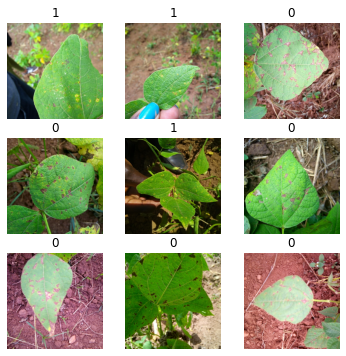

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")


In [3]:
print(info)

def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

# redimensionando exemplos e normalizando entre 0-1 tipo float32
img_size = (128, 128)
train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, img_size), tf.one_hot(y,3)))
train_ds = train_ds.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, img_size), tf.one_hot(y,3)))
validation_ds = validation_ds.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, img_size), tf.one_hot(y,3)))
test_ds = test_ds.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

input_shape = img_size+(3,)

tfds.core.DatasetInfo(
    name='beans',
    version=0.1.0,
    description='Beans is a dataset of images of beans taken in the field using smartphone
cameras. It consists of 3 classes: 2 disease classes and the healthy class.
Diseases depicted include Angular Leaf Spot and Bean Rust. Data was annotated
by experts from the National Crops Resources Research Institute (NaCRRI) in
Uganda and collected by the Makerere AI research lab.',
    homepage='https://github.com/AI-Lab-Makerere/ibean/',
    features=FeaturesDict({
        'image': Image(shape=(500, 500, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=1295,
    splits={
        'test': 128,
        'train': 1034,
        'validation': 133,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {beansdata,
        author="Makerere AI Lab",
        title="Bean disease dataset",
        month="January",
        year="2020",
        url="https://git

In [4]:
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

---

### Data Augmentation: 
#### funciona como uma camada de pré-processamento, gerando transformações aleatórias na imagem de entrada. 

Ao longo das épocas é responsável pela perturbação da entrada.

In [5]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomFlip("vertical"),
        layers.experimental.preprocessing.RandomRotation(0.25),
        layers.experimental.preprocessing.RandomContrast(0.3),
    ]
)

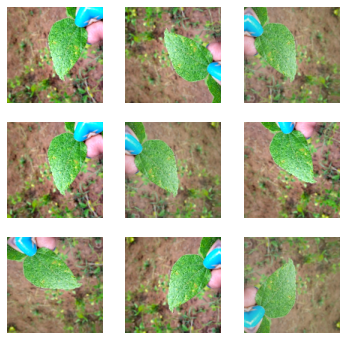

In [6]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(6, 6))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(images[1], 0), training=True
        )
        #plt.title(str(labels[i].numpy()))
        plt.imshow(augmented_image[0].numpy())
        plt.axis("off")


--- 
### Carregando a CNN "MobileNet V2" para ser usada como "backbone" da solução

**Abordagem 1**: pesos inicializados aleatoriamente

carregamos `include_top=False` pois não queremos a última camada (top), especifica da ImageNet


In [7]:
base_model_random = tf.keras.applications.MobileNetV2(
    weights=None,#nao carrega os pesos pre treinados
    input_shape=(128, 128, 3),
    include_top=False
)

# Permitir treinamento do modelo carregado
base_model_random.trainable = True

# Com base na MobileNetV2 vamos criar nosso modelo
# definimos o tamanho da entrada
inputs = keras.Input(shape=(128, 128, 3))
# aplicamos a transformacao da imagem de entrada
x = data_augmentation(inputs)

# Depois da "aumentacao de dados", temos o modelo base
x = base_model_random(x, training=True)
x = keras.layers.GlobalAveragePooling2D(name="avg_pool")(x)
x = keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(3,activation="softmax")(x)

model_random = keras.Model(inputs, outputs)

model_random.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 128, 128, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_128 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 2,227,715
Non-trainable params: 34,112
______________________________________________

#### Compilando e treinando o modelo a partir de pessos aleatórios

In [8]:
seed(1)
set_seed(2)

model_random.compile(
    optimizer=keras.optimizers.Adam(0.0001),
    loss="categorical_crossentropy",
    metrics=["acc"],
)

epochs = 20
rand_hist = model_random.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/20
17/17 [==============================] - 40s 257ms/step - loss: 1.1572 - acc: 0.3288 - val_loss: 1.1006 - val_acc: 0.3383
Epoch 2/20
17/17 [==============================] - 2s 136ms/step - loss: 1.1409 - acc: 0.3868 - val_loss: 1.0842 - val_acc: 0.3835
Epoch 3/20
17/17 [==============================] - 2s 130ms/step - loss: 1.1166 - acc: 0.4062 - val_loss: 1.0767 - val_acc: 0.4060
Epoch 4/20
17/17 [==============================] - 2s 131ms/step - loss: 1.1127 - acc: 0.3946 - val_loss: 1.0717 - val_acc: 0.4436
Epoch 5/20
17/17 [==============================] - 2s 130ms/step - loss: 1.0627 - acc: 0.4797 - val_loss: 1.0468 - val_acc: 0.4060
Epoch 6/20
17/17 [==============================] - 2s 131ms/step - loss: 1.0973 - acc: 0.4545 - val_loss: 1.0236 - val_acc: 0.4286
Epoch 7/20
17/17 [==============================] - 2s 130ms/step - loss: 1.0695 - acc: 0.4797 - val_loss: 1.0139 - val_acc: 0.4662
Epoch 8/20
17/17 [==============================] - 2s 130ms/step - loss: 1

In [9]:
scores = model_random.evaluate(validation_ds)
print('Inicializacao Aleatoria. Scores: ', scores)

5/5 [==============================] - 0s 28ms/step - loss: 0.8629 - acc: 0.6241
Inicializacao Aleatoria. Scores:  [0.8628509044647217, 0.6240601539611816]


--- 
### Carregando a CNN "MobileNet V2" com pesos pré-treinados

**Abordagem 2**: uso de pesos pré-treinados na imagenet para Transferência de Aprendizado


Agora a MobileNet sera carregada com os pesos ja treinados, ou seja, ela nao será treinada com a nossa base de dados

In [10]:
base_model = tf.keras.applications.MobileNetV2(
    weights="imagenet",
    input_shape=(128, 128, 3),
    include_top=False
)

# Tornamos o modelo base não treinável, "congelando" os parâmetros
base_model.trainable = False

# Nosso modelo como anteriormente
inputs = keras.Input(shape=(128, 128, 3))
x = data_augmentation(inputs) 

# Incluindo a MobileNetV2 com parametros pré-treinados, mas ainda não treinável
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D(name="avg_pool")(x)
x = keras.layers.Dense(160,activation="relu", name="projection")(x)
x = keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(3,activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 128, 128, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_128 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 1280)              0         
_________________________________________________________________
projection (Dense)           (None, 160)               204960    
_________________________________________________________________
dropout_1 (Dropout)          (None, 160)               0         
______________________________________________________________

#### Passo 1: treinar apenas a camada de saída (softmax)


In [11]:
seed(1)
set_seed(2)

model.compile(
    optimizer=keras.optimizers.Adam(0.0001),
    loss="categorical_crossentropy",
    metrics=["acc"],
)

epochs = 16
pt_hist1 = model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/16
17/17 [==============================] - 5s 110ms/step - loss: 1.1999 - acc: 0.4429 - val_loss: 0.8419 - val_acc: 0.6241
Epoch 2/16
17/17 [==============================] - 1s 46ms/step - loss: 0.8829 - acc: 0.6228 - val_loss: 0.6541 - val_acc: 0.7444
Epoch 3/16
17/17 [==============================] - 1s 47ms/step - loss: 0.7347 - acc: 0.6809 - val_loss: 0.6051 - val_acc: 0.7444
Epoch 4/16
17/17 [==============================] - 1s 47ms/step - loss: 0.6881 - acc: 0.6847 - val_loss: 0.5819 - val_acc: 0.7368
Epoch 5/16
17/17 [==============================] - 1s 47ms/step - loss: 0.6622 - acc: 0.6963 - val_loss: 0.5138 - val_acc: 0.7669
Epoch 6/16
17/17 [==============================] - 1s 47ms/step - loss: 0.6278 - acc: 0.7447 - val_loss: 0.5203 - val_acc: 0.7669
Epoch 7/16
17/17 [==============================] - 1s 47ms/step - loss: 0.5543 - acc: 0.7582 - val_loss: 0.5084 - val_acc: 0.7820
Epoch 8/16
17/17 [==============================] - 1s 46ms/step - loss: 0.5986 - 

In [12]:
scores = model.evaluate(validation_ds)
print('Transferencia do Aprendizado de Representacaoes. Scores: ', scores)

5/5 [==============================] - 0s 27ms/step - loss: 0.4496 - acc: 0.8045
Transferencia do Aprendizado de Representacaoes. Scores:  [0.44956061244010925, 0.8045112490653992]


#### Passo 2: ajuste fino do restante dos parâmetros

Executamos mais algumas épocas para tentar melhorar as outras camadas

In [13]:
# des-congelando o modelo base, permitindo ser treinável

# modelo completo
base_model.trainable = True

# congelando as primeiras camadas, deixando apenas as ultimas treinaveis
for layer in base_model.layers[:-4]: 
    layer.trainable = False
    # congela tambem camadas de BN
    if isinstance(layer, keras.layers.BatchNormalization):
        layer._per_input_updates = {}
        
# verificando
for layer in base_model.layers[-8:]: print(layer, layer.trainable)      
# note a diferença no summary
model.summary()

<keras.layers.convolutional.DepthwiseConv2D object at 0x7f038ef2cf50> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f038eec9310> False
<keras.layers.advanced_activations.ReLU object at 0x7f038efa5290> False
<keras.layers.convolutional.Conv2D object at 0x7f038eecb510> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f038eebdcd0> True
<keras.layers.convolutional.Conv2D object at 0x7f038ef168d0> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f038eed3b50> True
<keras.layers.advanced_activations.ReLU object at 0x7f038eee08d0> True
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 128, 128, 3)       0         
______

In [14]:
# aqui definimos um passo/learning rate bem pequeno para o ajuste-fino
model.compile(
    optimizer=keras.optimizers.Adam(10e-7), 
    loss="categorical_crossentropy",
    metrics=["acc"],
)

epochs = 5
pt_hist2 = model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/5
17/17 [==============================] - 5s 105ms/step - loss: 0.4167 - acc: 0.8298 - val_loss: 0.4481 - val_acc: 0.8045
Epoch 2/5
17/17 [==============================] - 1s 48ms/step - loss: 0.4172 - acc: 0.8279 - val_loss: 0.4463 - val_acc: 0.8045
Epoch 3/5
17/17 [==============================] - 1s 48ms/step - loss: 0.4408 - acc: 0.8221 - val_loss: 0.4451 - val_acc: 0.8045
Epoch 4/5
17/17 [==============================] - 1s 49ms/step - loss: 0.4233 - acc: 0.8375 - val_loss: 0.4449 - val_acc: 0.8045
Epoch 5/5
17/17 [==============================] - 1s 49ms/step - loss: 0.4298 - acc: 0.8317 - val_loss: 0.4439 - val_acc: 0.7970


In [15]:
scores = model.evaluate(validation_ds)
print('Ajuste Fino. Scores validacao: ', scores)

5/5 [==============================] - 0s 27ms/step - loss: 0.4439 - acc: 0.7970
Ajuste Fino. Scores validacao:  [0.44394323229789734, 0.7969924807548523]


Comparando o histórico das duas abordagens

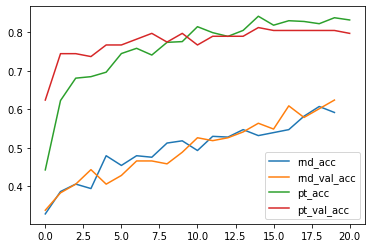

In [16]:
pt_tra_hist = np.concatenate((pt_hist1.history['acc'], pt_hist2.history['acc']), axis=None)
pt_val_hist = np.concatenate((pt_hist1.history['val_acc'], pt_hist2.history['val_acc']), axis=None)

plt.plot(rand_hist.history['acc'])
plt.plot(rand_hist.history['val_acc'])
plt.plot(pt_tra_hist)
plt.plot(pt_val_hist)
plt.legend(['rnd_acc','rnd_val_acc','pt_acc','pt_val_acc'])

--- 
### Obtendo features a partir da CNN "MobileNet V2" com pesos pré-treinados

**Abordagem 3**: obter a saída dessa rede, sem incluir a camada de predição (softmax).

Esse processo *não necessita de treinamento* da rede. Para obter features, incluímos uma nova camada, de Global Pooling e definimos essa camada como sendo a de saída do modelo.

Aqui também não incluimos o "topo" da rede, cujas camadas dependem de uma entrada de tamanho igual a da ImageNet (224x224) e saída com 1000 classes.

In [17]:
# carregando pessos pré-treinados
base_model_extraction = keras.applications.MobileNetV2(
    weights="imagenet",
    input_shape=(128, 128, 3),
    include_top=False
)

# obtemos a camada de saída do modelo carregado (última camada pois não incluímos o topo da rede)
base_output = base_model_extraction.layers[-1].output

# para evitar uma dimensionalidade alta, definimos uma nova camada de saída
feat_layer = keras.layers.GlobalAveragePooling2D()(base_output)

# montamos um novo modelo com a entrada do pré-treinado, e saída criada acima
model_imagenet = keras.models.Model(base_model_extraction.inputs, feat_layer)

# passando os exemplos de treinamento pela rede sem treinamento
# o "predict" vai nos dar a saída programada, obtida da GlobalAveragePooling2D
features_train_mobilenet = np.array(model_imagenet.predict(train_ds))
features_val_mobilenet = np.array(model_imagenet.predict(validation_ds))
features_test_mobilenet = np.array(model_imagenet.predict(test_ds))

print('\tDados x features obtidas treinamento: ', features_train_mobilenet.shape)
print('\tDados x features obtidas test: ', features_test_mobilenet.shape)

	Dados x features obtidas treinamento:  (517, 1280)
	Dados x features obtidas test:  (128, 1280)


As features obtidas podem ser utilizadas para treinar classificadores não profundos ou como índices de sistemas de recuperação baseada em conteúdo.

Vamos visualizá-las utilizando uma projeção PCA em duas dimensões

In [18]:
from sklearn.decomposition import PCA

# pca com dados da ImageNet
pca = PCA(n_components=2)
pca.fit(features_train_mobilenet)
pca_train_imagenet = pca.transform(features_train_mobilenet)

In [19]:
print(pca.explained_variance_ratio_)

[0.09472617 0.07667255]


In [20]:
# obtem labels treinamento
train_ds2 = train_ds.map(lambda x, y: (x, tf.math.argmax(y,axis=1)))
train_labels = list(np.concatenate([y for x, y in train_ds2], axis=0))

# obtem labels da validacao
validation_ds2 = validation_ds.map(lambda x, y: (x, tf.math.argmax(y,axis=1)))
val_labels = list(np.concatenate([y for x, y in validation_ds2], axis=0))

# obtem labels do teste
test_ds2 = test_ds.map(lambda x, y: (x, tf.math.argmax(y,axis=1)))
test_labels = list(np.concatenate([y for x, y in test_ds2], axis=0))

In [21]:
pca_train_imagenet.shape

(517, 2)

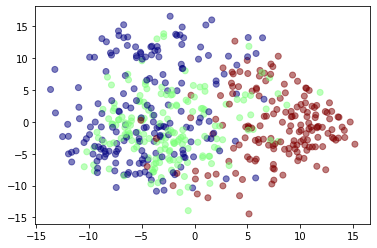

In [22]:
colors = ((np.array(train_labels)/2)*100).astype(int)
plt.scatter(pca_train_imagenet[:,0], pca_train_imagenet[:,1], c=colors, alpha=0.5, cmap='jet')

Usando em um classificador externo

In [23]:
from sklearn.svm import SVC

svm_feat1 = SVC(C=10, probability=True)
svm_feat1.fit(features_train_mobilenet, train_labels)

SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [24]:
print('Acurácia Treinamento:')
print(svm_feat1.score(features_train_mobilenet, train_labels))
print('Acurácia Validacao:')
print(svm_feat1.score(features_val_mobilenet, val_labels))

Acurácia Treinamento:
1.0
Acurácia Validacao:
0.8872180451127819


---
Resumo comparativo das abordagens:

1. Treinamento a partir de pesos aleatórios
2. Pré-treinamento + Transferência de Aprendizado e Ajuste Fino
3. Extração de Características + Classificador Externo

In [25]:
scoresR = model_random.evaluate(test_ds, verbose=0)
scoresTL = model.evaluate(test_ds, verbose=0)
scoresF = svm_feat1.score(features_test_mobilenet, test_labels)

print('MobileNet treinada de pesos aleatorios: ', scoresR[1]*100)
print('MobileNet pré-treinada + ajuste fino: ', scoresTL[1]*100)
print('Features MobileNet + SVM: ', scoresF*100)

MobileNet treinada de pesos aleatorios:  61.71875
MobileNet pré-treinada + ajuste fino:  80.46875
Features MobileNet + SVM:  91.40625
